<a href="https://colab.research.google.com/github/MarijanMarkovic/Numerical-modelling-of-differential-equations/blob/main/Parabolic_vj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:fenics-packages/fenics
!apt-get update -qq
!apt install -y --no-install-recommends fenics
!rm -rf *

In [ ]:
from fenics import*
import matplotlib.pyplot as plt

#1. Mesh Gen
nx, ny=10, 10
mesh=UnitSquareMesh(nx, ny, 'crossed')

#2. Finite Element Space
degree=1
V=FunctionSpace(mesh, 'CG', degree)

g_boundary=Constant(0.0)

def boundary(x, on_boundary):
  return on_boundary

bc=DirichletBC(V, g_boundary, boundary)

#3. Problem Definition
u_ex=Expression('1 + 0.5 * sin(omega * time) * sin(2 * pi * m * x[0]) * sin(2 * pi * n * x[1])',
                 degree=degree*2+1, domain=mesh, time=0.0, omega=pi, m=0.5, n=0.5)
u_old=project(u_ex, V)
f=Expression('0.5 * (omega * cos(omega * time) + 4 * (m * m + n * n) * pi * pi * sin(omega * time)) * sin(2 * pi * m * x[0]) * sin(2 * pi * n * x[1])',
               degree=degree+1, time=0.0, omega=pi, m=0.5, n=0.5)

Tfin = 1.0
dt = 0.1
theta = 0.0

u = TrialFunction(V)
v = TestFunction(V)

a = (u * v / dt + theta * inner(grad(u), grad(v))) * dx
L1 = ((u_old * v / dt) - (1 - theta) * inner(grad(u_old), grad(v)))* dx
L2 = f * v * dx

# 4. Solve the problem
A = assemble(a)
bc.apply(A)
Ainv = LUSolver(A)

t = 0

f.time = t
u_ex.time = t

l2err = errornorm(u_ex, u_old, 'L2')
h1err = errornorm(u_ex, u_old, 'H10')

while t < Tfin:
  b21 = assemble(L2)

  t += dt

  f.time = t
  b1 = assemble(L1)
  b22 = assemble(L2)

  b = b1 + theta * b22 + (1 - theta) * b21
  bc.apply(b)

  Ainv.solve(u_old.vector(), b)

  u_ex.time = t
  l2err = max(l2err, errornorm(u_ex, u_old, 'L2'))
  h1err = max(h1err, errornorm(u_ex, u_old, 'H10'))

print('L2 = {:.4e}'.format(l2err))
print('H1 = {:.4e}'.format(h1err))


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


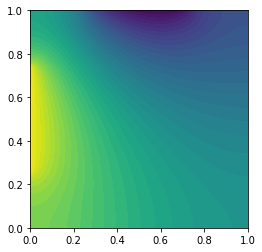

In [ ]:
from fenics import*
import matplotlib.pyplot as plt

#1. Mesh Gen
nx, ny=50, 50
mesh=UnitSquareMesh(nx, ny, 'crossed')
dim=mesh.geometric_dimension()

boundary_markers=MeshFunction('size_t', mesh, dim-1, 0)
boundary_markers.rename('boundary label', 'boundary')

class Boundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary
  
class DirichletBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[0], 0.0) and (0.25 <= x[1] <=0.75)
  
class RobinBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[1], 1.0) and (0.25 <= x[0] <=0.75);

Boundary().mark(boundary_markers, 1)
DirichletBoundary().mark(boundary_markers, 2)
RobinBoundary().mark(boundary_markers, 3)

dx=Measure('dx', domain=mesh)
ds=Measure('ds', domain=mesh, subdomain_data=boundary_markers)


#2. Finite Element Space
degree=1
V=FunctionSpace(mesh, 'CG', degree)

gD=Constant(40.0)
bc=DirichletBC(V, gD, boundary_markers, 2)

#3. Definition of the problem
k=Constant(1.e-2)
alpha=Constant(1.e-2)
Tfin=200
dt=5

uEnv=Constant(5.0)

u=TestFunction(V)
v=TrialFunction(V)

u_old=project(Constant(20.0), V)
u_old.rename('temperature', 'temperature')

a=(u * v/dt + k* dot(grad(u), grad(v))) * dx + alpha * u * v *ds(3)
L=u_old * v/dt * dx + alpha * uEnv * v * ds(3)

#4. Assembling/Solving
A=assemble(a)
bc.apply(A)
Ainv=LUSolver(A)

t=0
VTKfile = File('parabolic_vj2.pvd')
VTKfile << (u_old, t)

while t<Tfin:
  t+=dt
  b=assemble(L)
  bc.apply(b)
  
  Ainv.solve(u_old.vector(), b)
  plot(u_old)
  VTKfile << (u_old, t)

# New Section